# SIS hyperparameters
Generate an epidemic with some unknown "true" $(\lambda, \rho)$, then try to infer them by doing a grid search and comparing the log-likelihood (negative Bethe free energy)

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [2]:
include("../../telegram/notifications.jl")

default_tg_text (generic function with 1 method)

In [3]:
# fout = open("sis_hyperparams_out.txt", "a")
# ferr = open("sis_hyperparams_err.txt", "a")
# redirect_stdio(; stderr=ferr, stdout=fout)

In [24]:
T = 15
N = 100
k = 4
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
# t = SimpleGraph(prim_mst(gg))
# g = IndexedGraph(t)
# @assert is_connected(g)
# t = binary_tree(12)
# g = IndexedGraph(t)
# N = nv(g)
# @show N
λ_true = 0.4
ρ_true = 0.2
γ = 0.1;

In [25]:
sis_true = SIS(g, λ_true, ρ_true, T; γ)
X, _ = onesample(mpbp(sis_true));

In [26]:
sum(X[:,1] .== INFECTED)

5

In [27]:
mean(X .== INFECTED)

0.61375

In [28]:
lambdas = 0.3:0.02:0.5
rhos = 0.1:0.02:0.3
f = fill!(lambdas*rhos', 0);

In [29]:
# nobs = (T*N)
# last_time = false
nobs = N
last_time = true;

In [30]:
svd_trunc=TruncBond(10);

In [31]:
@telegram "sis hyperparams" begin
    
    for i in eachindex(lambdas)
        λ = lambdas[i]
        println("## λ $i of ", length(lambdas))
        for j in eachindex(rhos)
            println("   ## ρ $j of ", length(rhos))
            ρ = rhos[j]
#             for i in eachindex(bp.w)
#                 bp.w[i] .= (SISFactor(λ, ρ),) 
#             end
            bp = mpbp(SIS(g, λ, ρ, T; γ))
            reset!(bp)
            rng = MersenneTwister(0)
            draw_node_observations!(bp.ϕ, X, nobs; rng, last_time)
        
            iterate!(bp; maxiter=100, tol=1e-3, showprogress=false, svd_trunc)
            f[i,j] = bethe_free_energy(bp)
#             lp, ll = logprior_loglikelihood(bp, X)
#             f[i,j] = -lp
        end
    end
    
end

## λ 1 of 11
   ## ρ 1 of 11
   ## ρ 2 of 11
   ## ρ 3 of 11
   ## ρ 4 of 11
   ## ρ 5 of 11
   ## ρ 6 of 11
   ## ρ 7 of 11
   ## ρ 8 of 11
   ## ρ 9 of 11
   ## ρ 10 of 11
   ## ρ 11 of 11
## λ 2 of 11
   ## ρ 1 of 11
   ## ρ 2 of 11
   ## ρ 3 of 11
   ## ρ 4 of 11
   ## ρ 5 of 11
   ## ρ 6 of 11
   ## ρ 7 of 11
   ## ρ 8 of 11
   ## ρ 9 of 11
   ## ρ 10 of 11
   ## ρ 11 of 11
## λ 3 of 11
   ## ρ 1 of 11
   ## ρ 2 of 11
   ## ρ 3 of 11
   ## ρ 4 of 11
   ## ρ 5 of 11
   ## ρ 6 of 11
   ## ρ 7 of 11
   ## ρ 8 of 11
   ## ρ 9 of 11
   ## ρ 10 of 11
   ## ρ 11 of 11
## λ 4 of 11
   ## ρ 1 of 11
   ## ρ 2 of 11
   ## ρ 3 of 11
   ## ρ 4 of 11
   ## ρ 5 of 11
   ## ρ 6 of 11
   ## ρ 7 of 11
   ## ρ 8 of 11
   ## ρ 9 of 11
   ## ρ 10 of 11
   ## ρ 11 of 11
## λ 5 of 11
   ## ρ 1 of 11
   ## ρ 2 of 11
   ## ρ 3 of 11
   ## ρ 4 of 11
   ## ρ 5 of 11
   ## ρ 6 of 11
   ## ρ 7 of 11
   ## ρ 8 of 11
   ## ρ 9 of 11
   ## ρ 10 of 11
   ## ρ 11 of 11
## λ 6 of 11
   ## ρ 1 of 11
   ## ρ 2 of 11


In [32]:
# close(fout); close(ferr)

SIS - Inference of hyperparameters for 1 realization of an epidemic with N=100, T=15, 
    100 random observations
Matrix size: 10


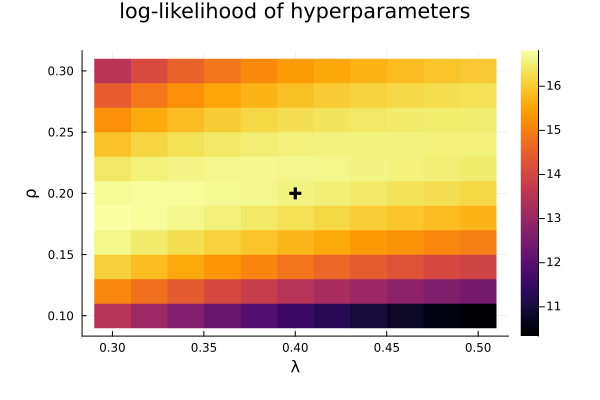

In [38]:
println("SIS - Inference of hyperparameters for 1 realization of an epidemic with N=$N, T=$T, 
    $nobs random observations")
println("Matrix size: $(svd_trunc.mprime)")
plot(lambdas, rhos, -f',title="log-likelihood of hyperparameters", xlabel="λ", ylabel="ρ", 
    fill=true, levels=30, st=:heatmap)
scatter!([λ_true], [ρ_true], m=:plus, label="", c=:black, msw=4, ms=6, margin=6Plots.mm)

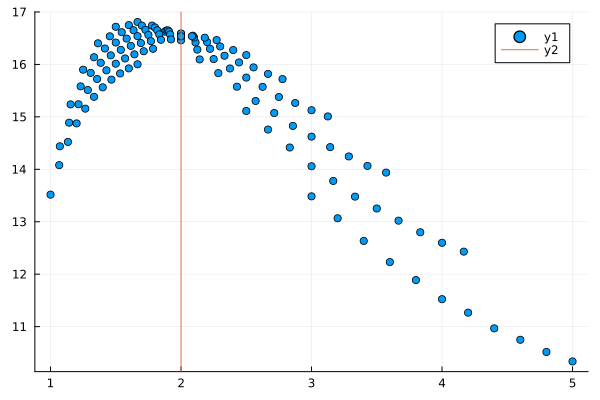

In [39]:
ratios = lambdas ./ rhos'
scatter(ratios[:], -f[:])
vline!([λ_true / ρ_true])

In [40]:
i, j = Tuple(argmax(-f))
lambda_max = lambdas[i]
rho_max = rhos[j]
(lambda_max, rho_max), (λ_true, ρ_true)

((0.3, 0.18), (0.4, 0.2))